In [1]:
# set up notebook to show plots within the notebook
%matplotlib inline

# Import necessary libraries:
# General utilities:
import os
import sys
from time import time
# from scipy.misc import imsave

# Computation:
import numpy as np
import h5py
from skimage import measure
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist 

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import ImageGrid

# Finally, pycroscopy itself
sys.path.append('../../../')
import pycroscopy as px
import pyUSID as usid
import sidpy

/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [2]:
h5_path = '/Users/sulaymandesai/Documents/Year_4/MSciProject/LoadData/h5/default_2017Jun09-162147_STM-STM_Spectroscopy--11_1_up-fwd.h5'

In [3]:
h5_file = h5py.File(h5_path, mode='r+')
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [4]:
usid.hdf_utils.print_tree(h5_file, main_dsets_only=True)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data


In [5]:
h5_main = usid.USIDataset(h5_file['/Measurement_000/Channel_000/Raw_Data'])

/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/io/dtype_utils.py:62: FutureWarning: pyUSID.io.dtype_utils.contains_integers has been moved to sidpy.base.num_utils.contains_integers. This copy in pyUSID willbe removed in future release. Please update your import statements
  warn('pyUSID.io.dtype_utils.contains_integers has been moved to '
/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/io/dtype_utils.py:38: FutureWarning: pyUSID.io.dtype_utils.lazy_load_array has been moved to sidpy.hdf.hdf_utils.lazy_load_array. This copy in pyUSID willbe removed in future release. Please update your import statements
  warn('pyUSID.io.dtype_utils.lazy_load_array has been moved to '


(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11c950a90>)

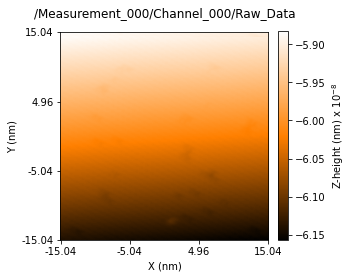

In [6]:
import spiepy

h5_main.visualize(figsize = (8,8), origin = 'lower', cmap = spiepy.NANOMAP)

In [7]:
h5_main

<HDF5 dataset "Raw_Data": shape (122500, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	Z-height (nm) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 350 
	X - size: 350 
Spectroscopic Dimensions: 
	arb. - size: 1
Data Type:
	float64

In [8]:
h5_pos = h5_main.parent[h5_main.attrs['Position_Indices']]

In [9]:
num_x = len(np.unique(h5_pos[:,0]))
num_y = len(np.unique(h5_pos[:,1]))

In [10]:
raw_image_mat = np.reshape(h5_main[()], [num_x,num_y])

In [11]:
raw_image_mat.shape

(350, 350)

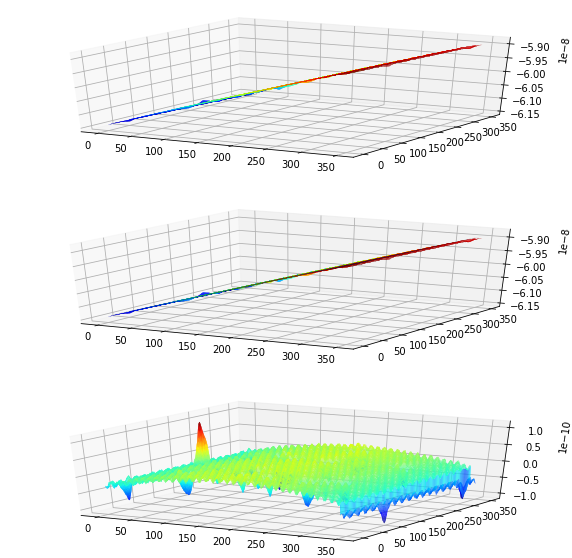

In [12]:
m = len(np.unique(h5_pos[:,0]))

X1, X2 = np.mgrid[:m, :m]

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(3,1,1, projection='3d')
jet = plt.get_cmap('jet')

#plot the initial topological surface
ax.plot_surface(X1,X2,raw_image_mat, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)

#Regression
X = np.hstack(( np.reshape(X1, (m*m, 1)), np.reshape(X2, (m*m, 1))))
X = np.hstack((np.ones((m*m, 1)), X ))
YY = np.reshape(raw_image_mat, (m*m, 1))

theta = np.dot(np.dot(np.linalg.pinv(np.dot(X.transpose(), X)), X.transpose()), YY)

plane = np.reshape(np.dot(X, theta), (m, m))

ax = fig.add_subplot(3,1,2, projection='3d')
ax.plot_surface(X1,X2,plane)
ax.plot_surface(X1,X2,raw_image_mat, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)

#Subtraction
Y_sub = raw_image_mat - plane
ax = fig.add_subplot(3,1,3, projection='3d')
ax.plot_surface(X1,X2,Y_sub, rstride = 1, cstride = 1, cmap = jet, linewidth = 0)

plt.show()

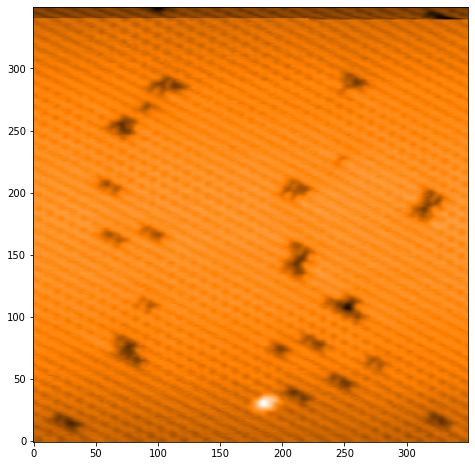

In [13]:
plt.figure(figsize = (8,8))
plt.imshow(Y_sub, origin = 'lower', cmap = spiepy.NANOMAP)

In [14]:
h5_main[()].shape

(122500, 1)

In [15]:
Y_sub.shape

(350, 350)

In [16]:
Y_sub_USID = Y_sub.reshape((Y_sub.shape[0] * Y_sub.shape[1], 1))

In [17]:
Y_sub_USID.shape

(122500, 1)

In [49]:
## Once run, comment out to prevent creating new group
# h5_results_group_1 = usid.hdf_utils.create_results_group(h5_main, 'Plane-Subtraction')
# print(h5_results_group_1)

<HDF5 group "/Measurement_000/Channel_000/Raw_Data-Plane_Subtraction_000" (0 members)>


/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/io/hdf_utils/simple.py:841: UserWarning: tool_name should not contain the "-" character. Reformatted name from:Plane-Subtraction to Plane_Subtraction
  warn('tool_name should not contain the "-" character. Reformatted name from:{} to '


In [50]:
## Once run, comment out to prevent creating new dataset

# h5_sub = usid.hdf_utils.write_main_dataset(h5_results_group_1,  # parent group
#                                             Y_sub_USID,  # data to be written
#                                             'Plane_Subtracted_Data',  # Name of the main dataset
#                                             'Plane-Subtracted Z-height',  # quantity
#                                             'nm',  # units
#                                             None,  # position dimensions
#                                             None,  # spectroscopic dimensions
#                                             h5_pos_inds=h5_main.h5_pos_inds,
#                                             h5_pos_vals=h5_main.h5_pos_vals,
#                                             h5_spec_inds=h5_main.h5_spec_inds,
#                                             h5_spec_vals=h5_main.h5_spec_vals)

/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/io/dtype_utils.py:358: FutureWarning: pyUSID.io.dtype_utils.validate_string_args has been moved to sidpy.base.string_utils.validate_string_args. This copy in pyUSID willbe removed in future release. Please update your import statements
  warn('pyUSID.io.dtype_utils.validate_string_args has been moved to '
/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/io/dtype_utils.py:62: FutureWarning: pyUSID.io.dtype_utils.contains_integers has been moved to sidpy.base.num_utils.contains_integers. This copy in pyUSID willbe removed in future release. Please update your import statements
  warn('pyUSID.io.dtype_utils.contains_integers has been moved to '
/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/io/dtype_utils.py:38: FutureWarning: pyUSID.io.dtype_utils.lazy_load_array has been moved to sidpy.hdf.hdf_utils.lazy_load_array. This copy in pyUSID willbe removed 

In [54]:
usid.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Raw_Data-Plane_Subtraction_000
      ------------------------------
      ├ Plane_Subtracted_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [55]:
usid.hdf_utils.print_tree(h5_file, main_dsets_only=True)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Raw_Data
    ├ Raw_Data-Plane_Subtraction_000
      ------------------------------
      ├ Plane_Subtracted_Data


In [56]:
h5_sub

<HDF5 dataset "Plane_Subtracted_Data": shape (122500, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data-Plane_Subtraction_000/Plane_Subtracted_Data 
Data contains: 
	Plane-Subtracted Z-height (nm) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 350 
	X - size: 350 
Spectroscopic Dimensions: 
	arb. - size: 1
Data Type:
	float64

(<Figure size 576x576 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11ce56ac0>)

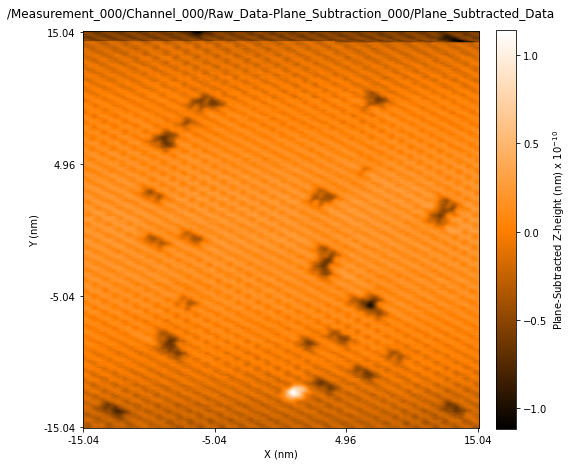

In [58]:
h5_sub.visualize(figsize = (8,8), origin = 'lower', cmap = spiepy.NANOMAP)